# Image processing performance optimisation

The idea of this tutorial is to give some suggestion how optimise image processing.
In the following example we decompress a CBF image from a Pilatus 6M, take the log-scale and calculate the histogram of pixel intensities before plotting. 
This very simple operation takes >300ms, what makes it unpractical for live display of images coming from a detector. 

In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [2]:
import time, os

start_time = time.time()
import silx

print("Using silx version ", silx.version)
from silx.resources import ExternalResources

downloader = ExternalResources(
    "pyFAI", "http://www.silx.org/pub/pyFAI/testimages", "PYFAI_DATA"
)
fname = downloader.getfile("powder_200_2_0001.cbf")
print("filename", os.path.basename(fname))
import fabio

nbins = 1000

Using silx version  0.7.0-dev0
filename powder_200_2_0001.cbf


/users/kieffer/VirtualEnvs/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
%%time

# Display an image and the histogram of values (in log scale)
img = fabio.open(fname).data
log_img = numpy.arcsinh(img)  # arcsinh is well behaved log-like function
his, edges = numpy.histogram(log_img, nbins)

CPU times: user 252 ms, sys: 32 ms, total: 284 ms
Wall time: 280 ms


<IPython.core.display.Javascript object>


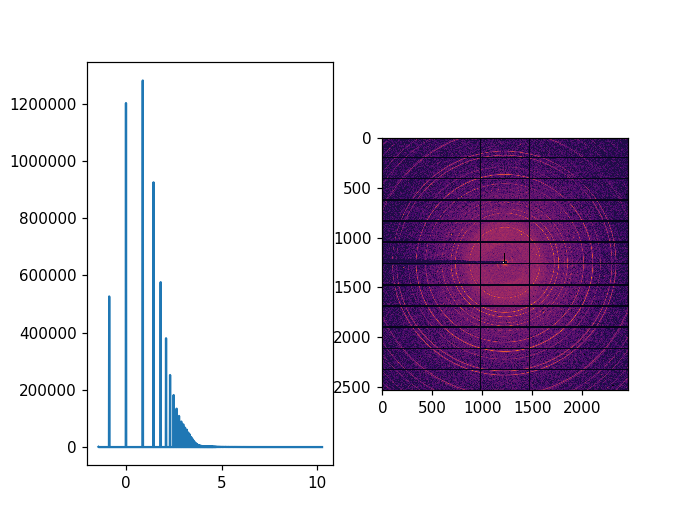

In [4]:
fig, ax = subplots(
    1,
    2,
)
center = (edges[1:] + edges[:-1]) / 2.0  # this is the center of the bins
ax[1].imshow(log_img, cmap="inferno")
ax[0].plot(center, his)

## Optimised GPU code

The code below prepares a GPU to be able to perform the same calculation as in the previous example.

3 operations have to be carried out:

* Decompress the CBF image
* Calculate the log scale (arcsinh values)
* Calculate the histogram

Both can be performed on the GPU without additional memory transfer

In [5]:
# switch this to "CPU" to have a fail safe
devicetype = "GPU"
from silx.opencl.codec.byte_offset import ByteOffset
from silx.opencl.image import ImageProcessing
import pyopencl, pyopencl.array, pyopencl.elementwise

cbf = fabio.cbfimage.CbfImage()
bo = ByteOffset(os.path.getsize(fname), img.size, devicetype=devicetype)
ash = pyopencl.elementwise.ElementwiseKernel(
    bo.ctx,
    arguments="float* data, float* res",
    operation="res[i] = asinh(data[i])",
    name="arcsinh_kernel",
)
ip = ImageProcessing(template=img, ctx=bo.ctx)
res = pyopencl.array.empty(bo.queue, img.shape, dtype=float32)

In [6]:
%%time
raw = cbf.read(fname, only_raw=True)
dec = bo(raw, as_float=True)
ash(dec, res)
his, edges = ip.histogram(res, nbins, copy=False)
log_img = res.get()

CPU times: user 16 ms, sys: 16 ms, total: 32 ms
Wall time: 28.8 ms


<IPython.core.display.Javascript object>


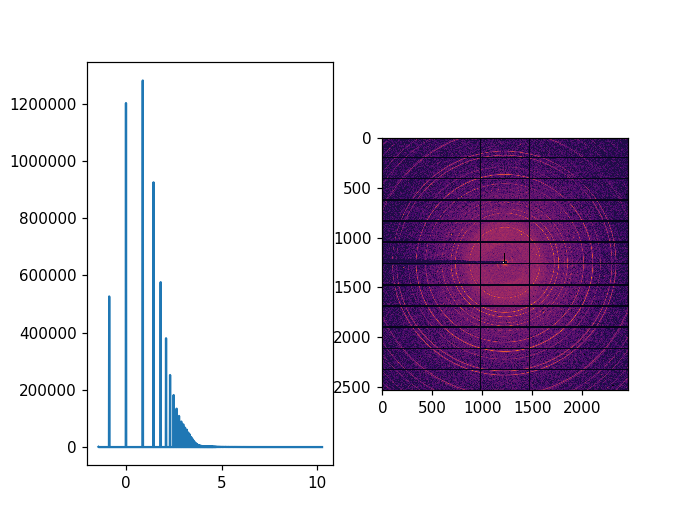

In [7]:
fig, ax = subplots(
    1,
    2,
)
center = (edges[1:] + edges[:-1]) / 2.0  # this is the center of the bins
ax[1].imshow(log_img, cmap="inferno")
ax[0].plot(center, his)

The results are the same and the processing time is 6x faster. Hence, one can envisage realtime visualisation of images coming from detectors.

## Investigation of the timings

In [8]:
ip.set_profiling(True)
bo.set_profiling(True)
ip.reset_log()
bo.reset_log()
raw = cbf.read(fname, only_raw=True)
dec = bo(raw, as_float=True)
ash(dec, res)
his, edges = ip.histogram(res, nbins, copy=False)
log_img = res.get()
import os

print(os.linesep.join(bo.log_profile()))
print(os.linesep.join(ip.log_profile()))


Profiling info for OpenCL ByteOffset
                                   copy raw H -> D:	0.972ms
                                       memset mask:	0.091ms
                                    memset counter:	0.005ms
                                   mark exceptions:	0.092ms
                               copy counter D -> H:	0.002ms
                                  treat_exceptions:	0.027ms
                                       double scan:	0.200ms
                                      copy_results:	0.141ms
________________________________________________________________________________
                              Total execution time:	1.530ms

Profiling info for OpenCL ImageProcessing
                                        copy D->D :	0.104ms
                                    max_min_stage1:	0.069ms
                                    max_min_stage2:	0.009ms
                                         histogram:	0.098ms
__________________________________________________________

## Conclusion
This notebook explains how to optimise some heavy numerical processing up to 10x speed-up for realtime image processing using GPU.